# Szybkie przypomnienie i kNN na dobry początek!

Na początku pobierzmy wymagane zbiory

In [1]:
!git clone https://github.com/PiotrJZielinski/ml-throwdown-datasets

fatal: destination path 'ml-throwdown-datasets' already exists and is not an empty directory.


In [2]:
import pandas as pd

def load_dataset(filename, class_column, index_col=None):
    dataset = pd.read_csv(f'ml-throwdown-datasets/{filename}.csv', index_col=index_col)
    dataset['class'] = dataset[class_column].astype('category').cat.codes
    classes = dataset.pop(class_column).unique()
    return dataset, classes

In [40]:
iris, iris_classes = load_dataset('iris', 'species')
print(iris_classes)

y = iris.pop('class')
X = iris

['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']


In [84]:
wine, wine_classes = load_dataset('wine', 'Class')
print(wine_classes)

y = wine.pop('class')
X = wine

['one' 'two' 'three']


In [21]:
# Zbiór treningowy i testowy
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [22]:
from sklearn.neighbors import KNeighborsClassifier

# Create and fit the model
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)

# Predict on the test features, print the results
pred = knn.predict(X_test)


In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# average:
#   None - wyniki dla każdej klasy osobno
#   'binary' - dla wybranej w `pos_label` etykiety
#   'micro' - dla całkowitej liczby TP, FN, FP
#   'macro' - nieważona średnia dla każdej klasy
#   'weighted' - ważona średnia dla każdej klasy

def calculate_metrics(target, prediction, average='micro'):
    accuracy = accuracy_score(target, prediction)
    precision = precision_score(target, prediction, average=average)
    recall = recall_score(target, prediction, average=average)
    f1 = f1_score(target, prediction, average=average)
    mislabeled = (target != prediction).sum()
    total = len(target)
    return accuracy, precision, recall, f1, mislabeled, total

def print_results(metrics, classifier_id='classifier'):
    print(f'Results for {classifier_id}')
    print('----')
    print(f'  Accuracy:  {metrics[0]}')
    print(f'  Precision: {metrics[1]}')
    print(f'  Recall:    {metrics[2]}')
    print(f'  F1 score:  {metrics[3]}')
    print(f'  Mislabeled {metrics[4]} out of {metrics[5]}')
    print('\n')

In [24]:
print_results(calculate_metrics(y_test, pred), 'kNN')

Results for kNN
----
  Accuracy:  0.7777777777777778
  Precision: 0.7777777777777778
  Recall:    0.7777777777777778
  F1 score:  0.7777777777777778
  Mislabeled 8 out of 36




Badania: wpływ kroswalidacaji, normalizacji, ilości sąsiadów, metody mierzenia odległości (Euklidesa, Manhattan, Czebyszewa, Mińkowskiego), sposobu głosowania (większościowe, ważone, ważone do kwadratu.

# Klasyfikacja liniowa, funkcja kosztu

W danych liniowo separowalnych, możemy użyć prostych funkcji do podziału binarnego, na przykład regresji liniowej. Regresja taka ma postać funkcji liniowej. Zacznijmy jednak od całkowitych podstaw, jak działają takie klasyfikatory, w tym celu napiszmy dwie proste tablice

In [26]:
import numpy as np

x = np.arange(3)
y = np.arange(3,6)

print(x,y)

[0 1 2] [3 4 5]


In [27]:
x*y

array([ 0,  4, 10])

In [28]:
np.sum(x*y)

14

To samo możemy uzyskać pisząc: to się nazywa dot product x.y w matematyce

In [29]:
x@y

14

I to jest we wzorze y = ax+b nasze ax, gdzie a, to współczynniki cech, a x to cechy. Tak działa predykcja w klasyfikatorach, również w perceptronach sieci. b natomiast to określony bias (początkowe obciążenie), również w postaci wektora cech

Przejdźmy do funkcji straty, w regresji liniowej często jest ona określana jako kwadrat różnicy między wartością oczekiwaną a predykowaną. W scikicie jest funkcja, która oblicza koszt dla określonej funkcji kosztu i zadanej wartości.

In [39]:
from scipy.optimize import minimize

minimize(np.square, 3).x

array([1.59339149e-08])

Zdefiniujmy teraz własną funkcję kosztu:

In [115]:
iris, iris_classes = load_dataset('iris', 'species')
print(iris_classes)

y = iris.pop('class')
X = iris

['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']


In [53]:
# The squared error, summed over training examples
def my_loss(w):
    s = 0
    for i in range(y.size):
        # Get the true and predicted target values for example 'i'
        y_i_true = y[i]
        y_i_pred = w@X.loc[i]
        s = s + (y_i_true - y_i_pred)**2
    return s

In [54]:
# Returns the w that makes my_loss(w) smallest
w_fit = minimize(my_loss, X.loc[0]).x
print(w_fit)

[-0.08449324 -0.02356131  0.2248715   0.59972266]


Porównajmy teraz wyniki z prawdziwym klasyfikatorem liniowym

In [55]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression(fit_intercept=False).fit(X,y)
print(lr.coef_)

[-0.0844926  -0.02356211  0.22487123  0.59972247]


Jak widzimy odwzorowoaliśmy funkcję fit B). Zdefiniujmy sobie teraz funkcje wykorzystywane w regresji logistycznej i w SVM

In [82]:
def log_loss(raw_model_output):
   return np.log(1 + np.exp(-raw_model_output))

def hinge_loss(raw_model_output):
   return np.maximum(0,1-raw_model_output)

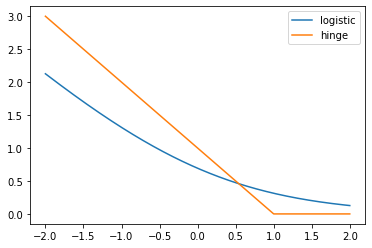

In [59]:
import matplotlib.pyplot as plt

# Create a grid of values and plot
grid = np.linspace(-2,2,1000)
plt.plot(grid, log_loss(grid), label='logistic')
plt.plot(grid, hinge_loss(grid), label='hinge')
plt.legend()
plt.show()

I zobaczmy, czy dostaniemy te same współczynniki funkcji, które da nam funkcja fit

In [134]:
diabetes, diabetes_class = load_dataset('diabetes', 'Class')
print(diabetes_class) #potrzbujemy zbioru z dwoma klasami, inaczej nasza funkcja nie zadziała na wielu wymiarach

y = diabetes.pop('class')
X = diabetes

['positive' 'negative']


In [136]:
from sklearn.linear_model import LogisticRegression

# The logistic loss, summed over training examples
def my_loss_2(w):
    s = 0
    for i in range(0,len(X)):
        raw_model_output = w@X.loc[i]
        s = s + log_loss(raw_model_output * y[i])
    return s

# Returns the w that makes my_loss(w) smallest
w_fit = minimize(my_loss_2, X.loc[0]).x
print(w_fit)

# Compare with scikit-learn's LogisticRegression
lr = LogisticRegression(fit_intercept=False, C=1000000000000000000).fit(X,y)
print(lr.coef_)

[  6.    148.     72.     35.      0.     33.6     0.627  50.   ]
[[ 1.28391838e-01  1.29356931e-02 -3.03246825e-02  1.94997253e-04
   7.38906982e-04 -4.81495164e-03  3.20276125e-01 -1.56309376e-02]]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


To powinno działać, dla prostrzych danych działa :/

Regularyzacja, czyli jak przeciwdziałać overfittingowi. Czy to jest w ogóle problem? Sprawdżmy!

['one' 'two' 'three']


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed

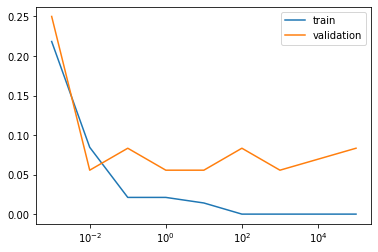

In [121]:
wine, wine_classes = load_dataset('wine', 'Class')
print(wine_classes)

y = wine.pop('class')
X = wine


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Train and validaton errors initialized as empty list
train_errs = list()
valid_errs = list()

C_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 100000]

# Loop over values of C_value
for C_value in C_values:
    # Create LogisticRegression object and fit
    lr = LogisticRegression(C=C_value)
    lr.fit(X_train, y_train)
    
    # Evaluate error rates and append to lists
    train_errs.append( 1.0 - lr.score(X_train, y_train))
    valid_errs.append( 1.0 - lr.score(X_test, y_test))
    
# Plot results
plt.semilogx(C_values, train_errs, C_values, valid_errs)
plt.legend(("train", "validation"))
plt.show()

Regularyzacja l1 udostępnia selekcję cech, o możemy zobaczyć tu:

In [123]:
from sklearn.model_selection import GridSearchCV

# Specify L1 regularization
lr = LogisticRegression(penalty='l1')

# Instantiate the GridSearchCV object and run the search
searcher = GridSearchCV(lr, {'C':[0.001, 0.01, 0.1, 1, 10]})
searcher.fit(X_train, y_train)

# Report the best parameters
print("Best CV params", searcher.best_params_)

# Find the number of nonzero coefficients (selected features)
best_lr = searcher.best_estimator_
coefs = best_lr.coef_
print("Total number of features:", coefs.size)
print("Number of selected features:", np.count_nonzero(coefs))

Best CV params {'C': 1}
Total number of features: 39
Number of selected features: 23


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_clas

Wraz ze wzrotem regularyzacji, maleje pewność wykrycia:
    

In [132]:
# Set the regularization strength
model = LogisticRegression(C=0.0001) # sprawdzić dla 1, itd.

# Fit and plot
model.fit(X,y)

# Predict probabilities on training points
prob = model.predict_proba(X)
print("Maximum predicted probability", np.max(prob))

Maximum predicted probability 0.9499852032716556


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Różnice między klasyfikatorami logistycznymi one vs rest, multinomial

In [137]:
# Fit one-vs-rest logistic regression classifier
lr_ovr = LogisticRegression()
lr_ovr.fit(X_train, y_train)

print("OVR training accuracy:", lr_ovr.score(X_train, y_train))
print("OVR test accuracy    :", lr_ovr.score(X_test, y_test))

# Fit softmax classifier
lr_mn = LogisticRegression(multi_class= 'multinomial', solver="lbfgs")
lr_mn.fit(X_train, y_train)

print("Softmax training accuracy:", lr_mn.score(X_train, y_train))
print("Softmax test accuracy    :", lr_mn.score(X_test, y_test))

OVR training accuracy: 0.9788732394366197
OVR test accuracy    : 0.9444444444444444
Softmax training accuracy: 0.9788732394366197
Softmax test accuracy    : 0.9444444444444444


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Przejdźmy teraz do SVMów

In [139]:
from sklearn.svm import SVC

# Train a linear SVM
svm = SVC(kernel="linear")
svm.fit(X,y)

# Make a new data set keeping only the support vectors
print("Number of original examples", len(X))
print("Number of support vectors", len(svm.support_))

Number of original examples 768
Number of support vectors 400


No dobrze, ale co w przypadku, gdy nasze dane nie są liniowo separowalne? Trzeba dokonać transofmracji. Do tego służy nam Kernel SVM

In [140]:
#gamma reguluje nam ilość przekształceń

# Instantiate an RBF SVM
svm = SVC()

# Instantiate the GridSearchCV object and run the search
parameters = {'gamma':[0.00001, 0.0001, 0.001, 0.01, 0.1]}
searcher = GridSearchCV(svm, parameters)
searcher.fit(X, y)

# Report the best parameters
print("Best CV params", searcher.best_params_)

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best CV params {'gamma': 0.0001}


Porównajmy sobie różne wartości regularyzacji i przekształceń gamma

In [142]:
# Instantiate an RBF SVM
svm = SVC()

# Instantiate the GridSearchCV object and run the search
parameters = {'C':[0.1, 1, 10], 'gamma':[0.00001, 0.0001, 0.001, 0.01, 0.1]}
searcher = GridSearchCV(svm, parameters)
searcher.fit(X_train, y_train)

# Report the best parameters and the corresponding score
print("Best CV params", searcher.best_params_)
print("Best CV accuracy", searcher.best_score_)

# Report the test accuracy using these best parameters
print("Test accuracy of best grid search hypers:", searcher.score(X_test, y_test))

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best CV params {'C': 10, 'gamma': 0.001}
Best CV accuracy 0.7676056338028169
Test accuracy of best grid search hypers: 0.7222222222222222


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
